In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import cv2
import random

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_dataset = pd.read_csv('sign_data/train_data.csv', header = None)
test_dataset = pd.read_csv('sign_data/test_data.csv', header = None)
train_dir = "sign_data/train"
test_dir = "sign_data/test"

In [4]:
class DataLoader:
    def __init__(self, dataset, batch_size, dir):
        self.dataset = dataset
        self.batch_size = batch_size
        self.dir = dir
    
    def shuffle(self):
        return self.dataset.sample(frac=1)
    
    def preprocess_image(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=1) 
        img = tf.image.resize(img, (128, 128))
        img = tf.cast(img, tf.uint8) 

        img_cv2 = cv2.Canny(img.numpy(), 20, 220) 
        
        img_cv2 = tf.cast(img_cv2, tf.float32) / 255.0
        
        return img_cv2
    
    def apply_random_transformations(self, image):
        # Apply random rotation (between -20 and 20 degrees)
        if random.random() < 0.5:  # 50% chance to rotate
            angle = random.uniform(-20, 20)  # Random angle between -20 and 20 degrees
            image = tfa.image.rotate(image, angle)
        
        return image
    
    def datagen(self):
        num_samples = len(self.dataset)
        while True:

            self.dataset = self.shuffle()
            for batch in range(0, num_samples, self.batch_size):
                image1_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 0]]
                image2_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 1]]
                label_batch_samples = self.dataset.iloc[batch:batch + self.batch_size, 2]
                Image1, Image2, Label = [], [], []
                for image1, image2, label in zip(image1_batch_samples, image2_batch_samples, label_batch_samples):

                    image1_data = self.preprocess_image(image1)
                    image2_data = self.preprocess_image(image2)
                    Image1.append(image1_data)
                    Image2.append(image2_data)
                    Label.append(label)
                    
                    image1_data = self.apply_random_transformations(image1_data)
                    image2_data = self.apply_random_transformations(image2_data)
                    
                    Image1.append(image1_data)
                    Image2.append(image2_data)
                    Label.append(label)
                    
                    if label == 0 and random.random() < 0.2:
                        Image1.append(image1_data)
                        Image2.append(image1_data)
                        Label.append(0)
                        Image1.append(image2_data)
                        Image2.append(image2_data)
                        Label.append(0)
                        

                Image1 = np.asarray(Image1)
                Image2 = np.asarray(Image2)
                Label = np.asarray(Label)
                yield {"image1": Image1, "image2": Image2}, Label

In [5]:
train_set, val_set = train_test_split(train_dataset, test_size=0.25)

# Create train, val and test 
train_gen = DataLoader(train_set, 256, train_dir)
val_gen = DataLoader(val_set, 256, train_dir)
test_gen = DataLoader(test_dataset, 256, test_dir)

In [6]:
# generator = train_gen.datagen()

# # Plot 5 1st images in batch
# for i in range(5):
#     batch_data, label = next(generator)
    
#     pair_data = batch_data["image1"], batch_data["image2"]
    
#     print(f"Pair {i+1}:")
#     print("Label:", label[0]) 
    
#     plt.figure(figsize=(10, 5))
#     for j in range(2):
#         plt.subplot(1, 2, j+1)
#         plt.imshow(pair_data[j][0], cmap='gray')
#         plt.title('Image {}'.format(j+1))
#         plt.axis('off')
    
#     plt.show()

In [7]:
def create_siamese_model(input_shape):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    
    input1 = Input(input_shape, name="image1")
    input2 = Input(input_shape, name="image2")

    embedding1 = model(input1)
    embedding2 = model(input2)

    manhattan_distance_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))
    manhattan_distance = manhattan_distance_layer([embedding1, embedding2])


    output = Dense(1, activation='sigmoid')(manhattan_distance)

    return Model(inputs=[input1, input2], outputs=output)

In [8]:
input_shape = (128, 128, 1) 

In [9]:
model = create_siamese_model(input_shape)
model.summary()
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image1 (InputLayer)            [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 image2 (InputLayer)            [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          2522624     ['image1[0][0]',                 
                                                                  'image2[0][0]']             

In [12]:
checkpoint = ModelCheckpoint("model_compare_signatures.kernel", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

callbacks_list = [checkpoint, early_stopping]

In [13]:
history = model.fit(
    train_gen.datagen(),                    # Training data generator with augmentation
    steps_per_epoch=len(train_set) // 256,     # Number of steps per epoch
    epochs=10,                                 # Number of epochs
    validation_data=val_gen.datagen(),        # Validation data generator with augmentation
    validation_steps=len(val_set) // 256,     # Number of validation steps
    callbacks=callbacks_list                  # Callbacks like ModelCheckpoint, EarlyStopping, etc.
)

Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 0.6440 - accuracy: 0.6402
Epoch 1: val_accuracy improved from -inf to 0.61313, saving model to model_compare_signatures.kernel


INFO:tensorflow:Assets written to: model_compare_signatures.kernel\assets


INFO:tensorflow:Assets written to: model_compare_signatures.kernel\assets


67/67 [==============================] - 611s 9s/step - loss: 0.6440 - accuracy: 0.6402 - val_loss: 0.6713 - val_accuracy: 0.6131
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 0.6029 - accuracy: 0.6791
Epoch 2: val_accuracy improved from 0.61313 to 0.69712, saving model to model_compare_signatures.kernel


INFO:tensorflow:Assets written to: model_compare_signatures.kernel\assets


INFO:tensorflow:Assets written to: model_compare_signatures.kernel\assets


67/67 [==============================] - 629s 9s/step - loss: 0.6029 - accuracy: 0.6791 - val_loss: 0.6188 - val_accuracy: 0.6971
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 0.5459 - accuracy: 0.7297
Epoch 3: val_accuracy improved from 0.69712 to 0.76540, saving model to model_compare_signatures.kernel


INFO:tensorflow:Assets written to: model_compare_signatures.kernel\assets


INFO:tensorflow:Assets written to: model_compare_signatures.kernel\assets


67/67 [==============================] - 629s 9s/step - loss: 0.5459 - accuracy: 0.7297 - val_loss: 0.5403 - val_accuracy: 0.7654
Epoch 4/10
67/67 [==============================] - ETA: 0s - loss: 0.4689 - accuracy: 0.7828
Epoch 4: val_accuracy improved from 0.76540 to 0.81481, saving model to model_compare_signatures.kernel


INFO:tensorflow:Assets written to: model_compare_signatures.kernel\assets


INFO:tensorflow:Assets written to: model_compare_signatures.kernel\assets


67/67 [==============================] - 632s 9s/step - loss: 0.4689 - accuracy: 0.7828 - val_loss: 0.4691 - val_accuracy: 0.8148
Epoch 5/10
67/67 [==============================] - ETA: 0s - loss: 0.4058 - accuracy: 0.8251
Epoch 5: val_accuracy improved from 0.81481 to 0.86361, saving model to model_compare_signatures.kernel


INFO:tensorflow:Assets written to: model_compare_signatures.kernel\assets


INFO:tensorflow:Assets written to: model_compare_signatures.kernel\assets


67/67 [==============================] - 684s 10s/step - loss: 0.4058 - accuracy: 0.8251 - val_loss: 0.3902 - val_accuracy: 0.8636
Epoch 6/10
67/67 [==============================] - ETA: 0s - loss: 0.3531 - accuracy: 0.8536 
Epoch 6: val_accuracy improved from 0.86361 to 0.88529, saving model to model_compare_signatures.kernel


INFO:tensorflow:Assets written to: model_compare_signatures.kernel\assets


INFO:tensorflow:Assets written to: model_compare_signatures.kernel\assets


67/67 [==============================] - 858s 13s/step - loss: 0.3531 - accuracy: 0.8536 - val_loss: 0.3419 - val_accuracy: 0.8853
Epoch 7/10
67/67 [==============================] - ETA: 0s - loss: 0.3125 - accuracy: 0.8731
Epoch 7: val_accuracy improved from 0.88529 to 0.89859, saving model to model_compare_signatures.kernel


INFO:tensorflow:Assets written to: model_compare_signatures.kernel\assets


INFO:tensorflow:Assets written to: model_compare_signatures.kernel\assets


67/67 [==============================] - 642s 10s/step - loss: 0.3125 - accuracy: 0.8731 - val_loss: 0.3093 - val_accuracy: 0.8986
Epoch 8/10
67/67 [==============================] - ETA: 0s - loss: 0.2808 - accuracy: 0.8878
Epoch 8: val_accuracy improved from 0.89859 to 0.90634, saving model to model_compare_signatures.kernel


INFO:tensorflow:Assets written to: model_compare_signatures.kernel\assets


INFO:tensorflow:Assets written to: model_compare_signatures.kernel\assets


67/67 [==============================] - 686s 10s/step - loss: 0.2808 - accuracy: 0.8878 - val_loss: 0.2903 - val_accuracy: 0.9063
Epoch 9/10
67/67 [==============================] - ETA: 0s - loss: 0.2620 - accuracy: 0.8969
Epoch 9: val_accuracy improved from 0.90634 to 0.91596, saving model to model_compare_signatures.kernel


INFO:tensorflow:Assets written to: model_compare_signatures.kernel\assets


INFO:tensorflow:Assets written to: model_compare_signatures.kernel\assets


67/67 [==============================] - 645s 10s/step - loss: 0.2620 - accuracy: 0.8969 - val_loss: 0.2675 - val_accuracy: 0.9160
Epoch 10/10
67/67 [==============================] - ETA: 0s - loss: 0.2377 - accuracy: 0.9059
Epoch 10: val_accuracy improved from 0.91596 to 0.92062, saving model to model_compare_signatures.kernel


INFO:tensorflow:Assets written to: model_compare_signatures.kernel\assets


INFO:tensorflow:Assets written to: model_compare_signatures.kernel\assets


67/67 [==============================] - 644s 10s/step - loss: 0.2377 - accuracy: 0.9059 - val_loss: 0.2490 - val_accuracy: 0.9206


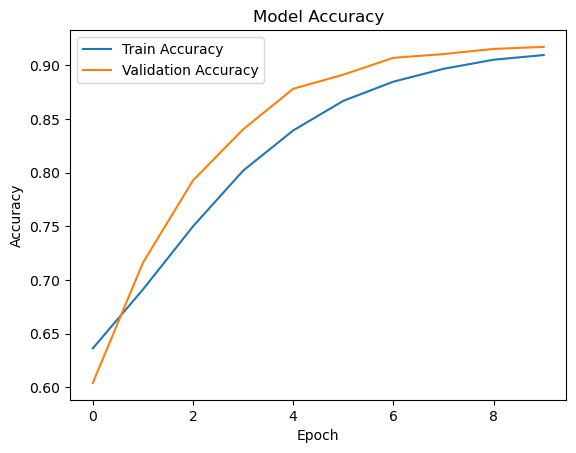

In [231]:
# Train and val model accuracy per epoch
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

In [232]:
# load weights
model.load_weights("model_compare_signatures.kernel")

In [233]:
test_loss, test_accuracy = model.evaluate(test_gen.datagen(),
                                          steps=len(test_dataset) // 256)

22/22 [==============================] - 85s 4s/step - loss: 0.2377 - accuracy: 0.9162


In [234]:
test_pairs, test_labels = next(test_gen.datagen())

In [235]:
test_predictions = model.predict(test_pairs)

# Conversion of predictions to binary format (0 or 1)
binary_predictions = (test_predictions > 0.5).astype(int)

18/18 [==============================] - 1s 65ms/step


Pair 202
True Label: 0
Predicted Label: [0]


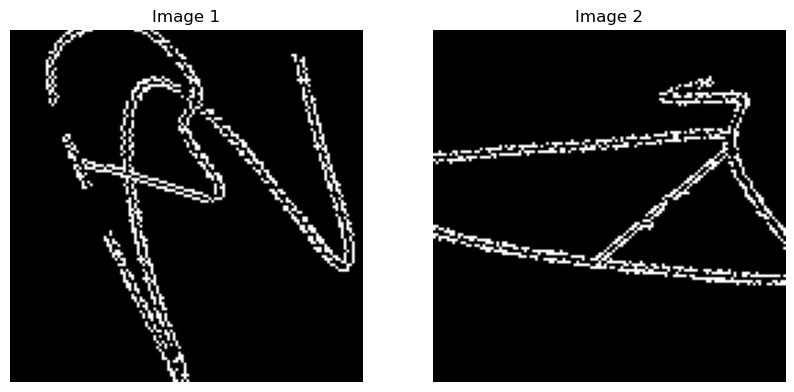

Pair 13
True Label: 0
Predicted Label: [0]


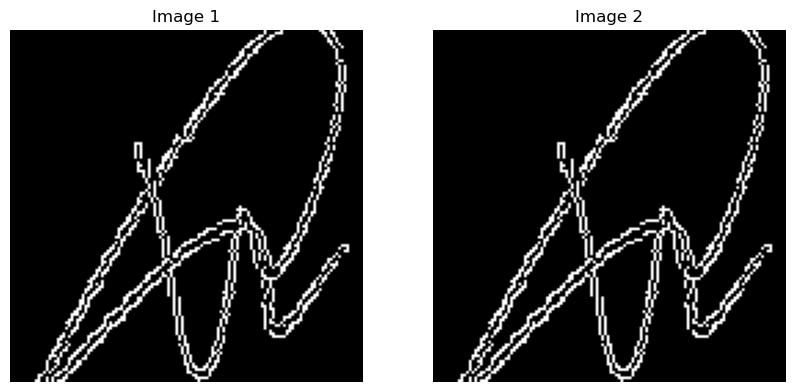

Pair 187
True Label: 1
Predicted Label: [1]


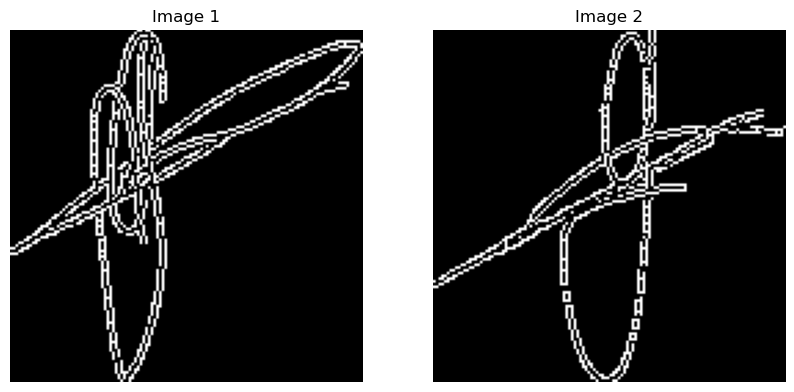

Pair 281
True Label: 1
Predicted Label: [1]


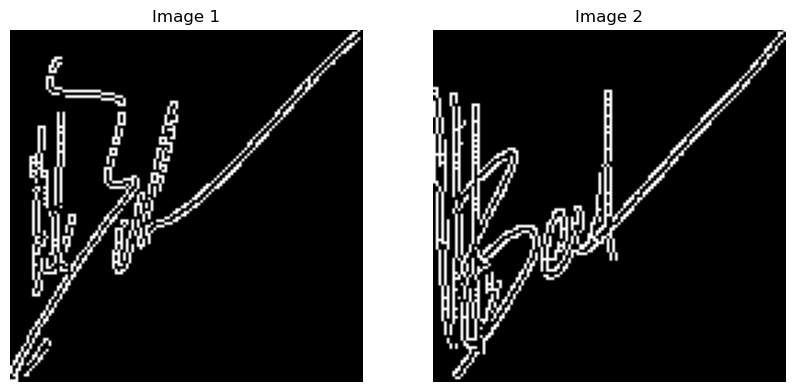

Pair 20
True Label: 1
Predicted Label: [1]


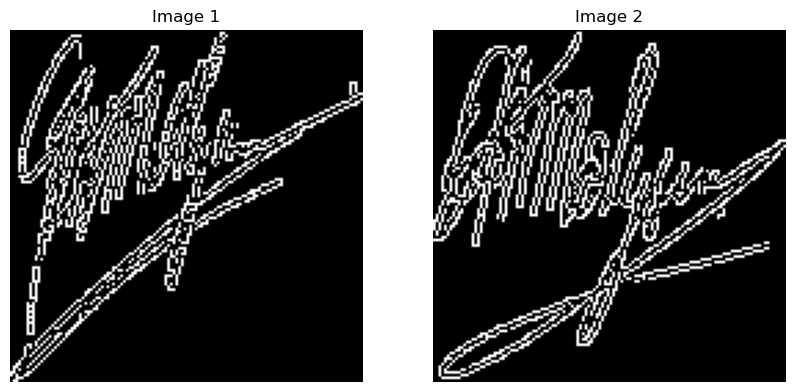

Pair 351
True Label: 0
Predicted Label: [0]


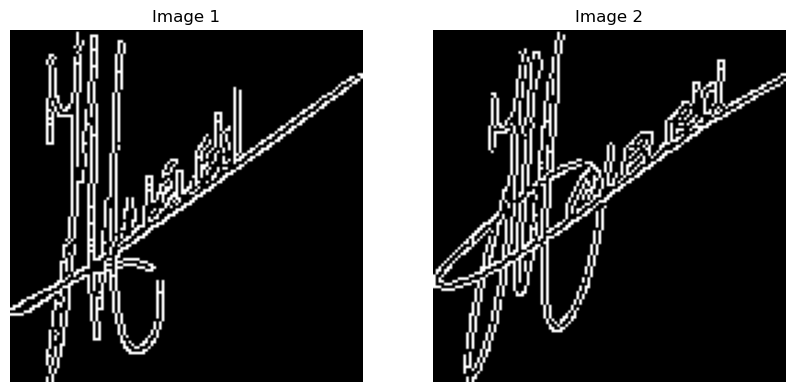

Pair 49
True Label: 0
Predicted Label: [0]


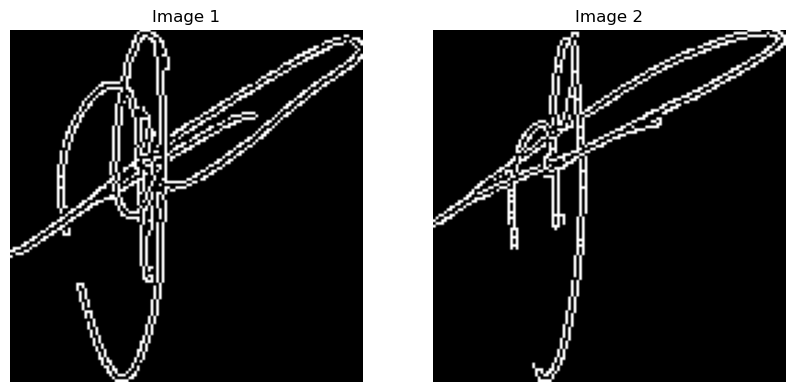

Pair 205
True Label: 0
Predicted Label: [0]


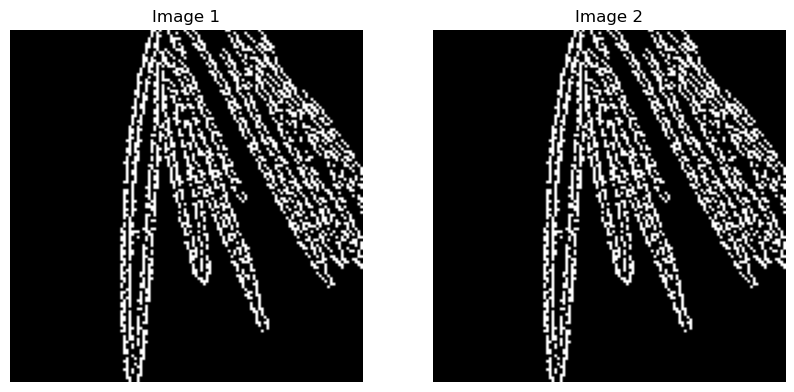

Pair 325
True Label: 1
Predicted Label: [1]


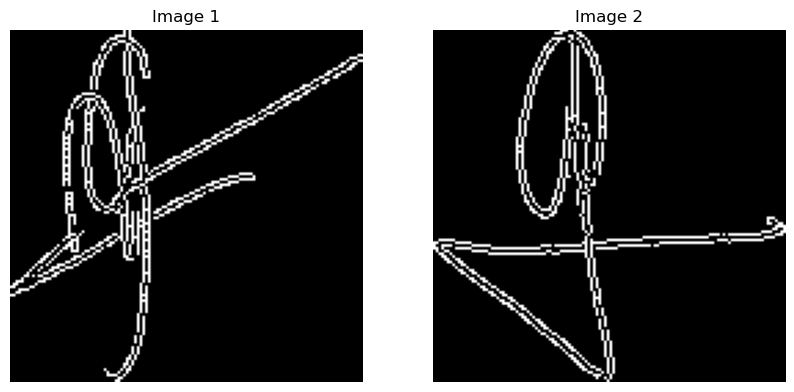

Pair 40
True Label: 1
Predicted Label: [0]


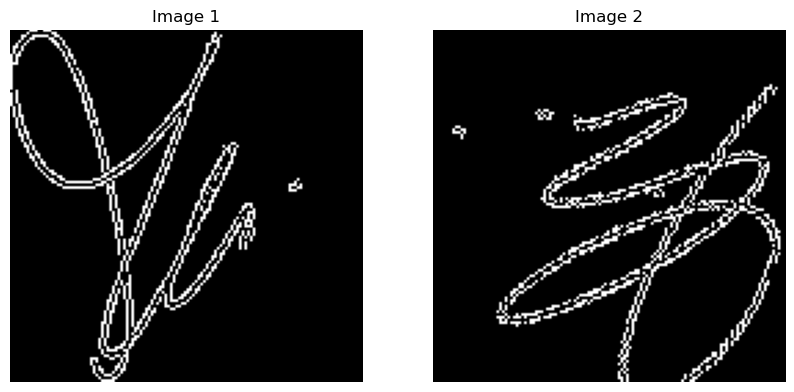

Pair 454
True Label: 0
Predicted Label: [0]


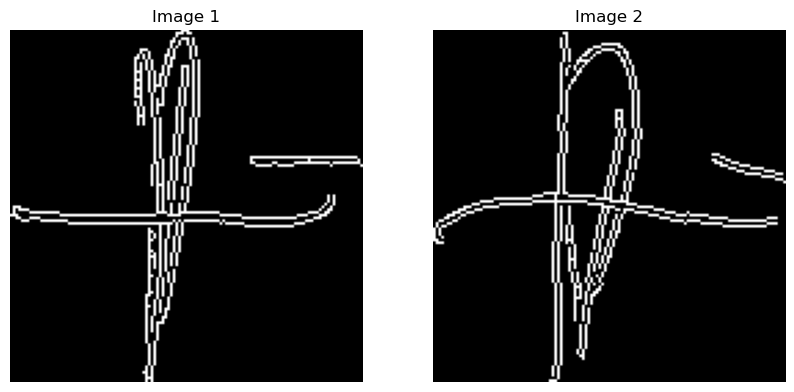

Pair 394
True Label: 0
Predicted Label: [0]


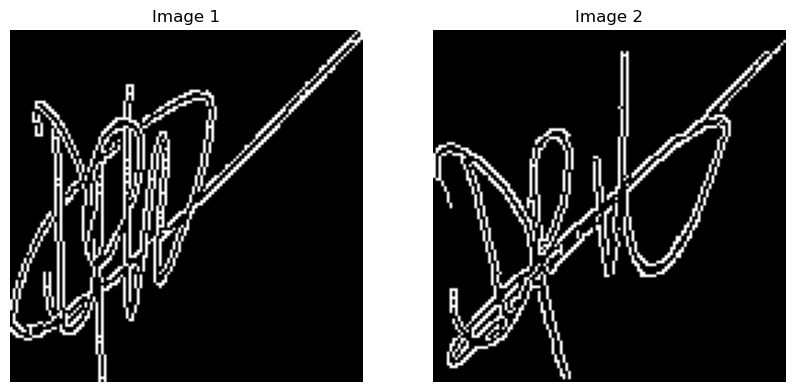

Pair 145
True Label: 1
Predicted Label: [1]


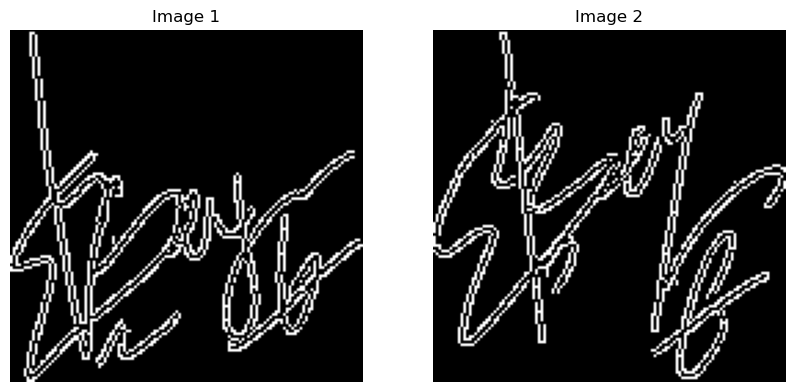

Pair 162
True Label: 0
Predicted Label: [0]


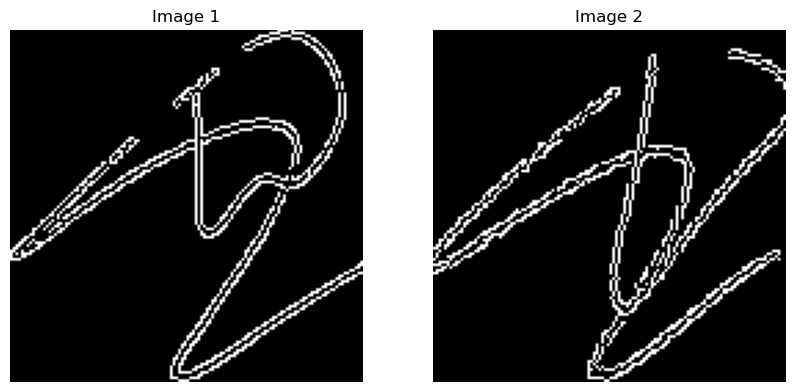

Pair 372
True Label: 1
Predicted Label: [1]


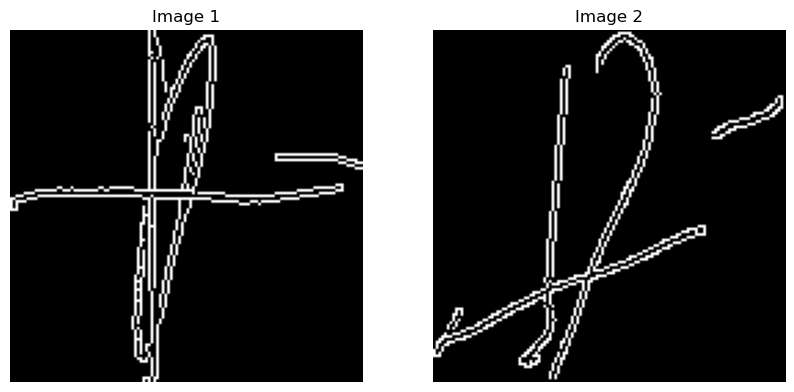

Pair 429
True Label: 1
Predicted Label: [1]


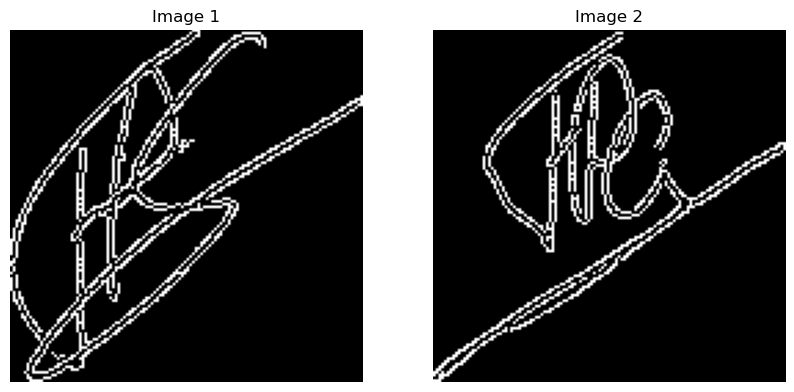

Pair 527
True Label: 1
Predicted Label: [1]


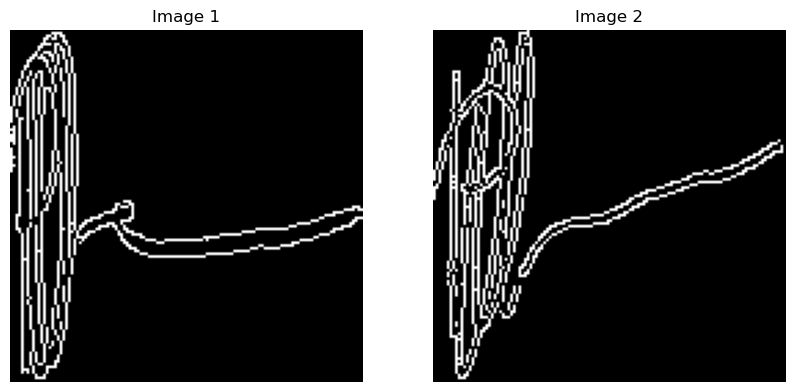

Pair 155
True Label: 0
Predicted Label: [0]


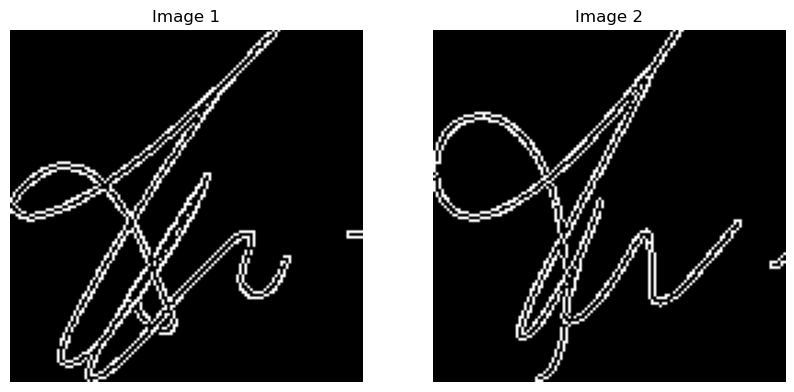

Pair 529
True Label: 1
Predicted Label: [1]


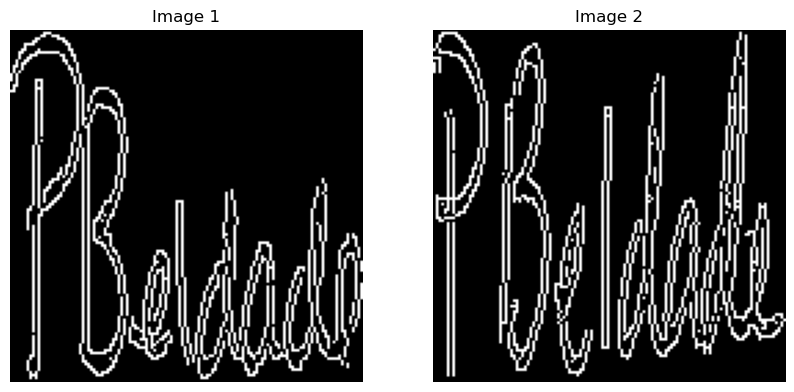

Pair 475
True Label: 1
Predicted Label: [1]


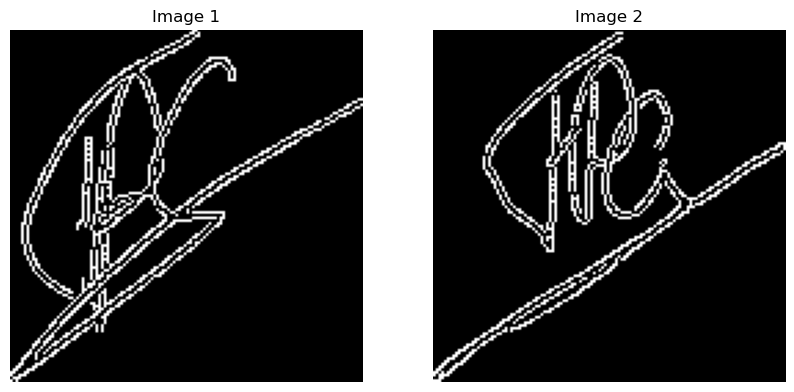

In [236]:
import random

# Getting random 20 pair indices for output
random_indices = random.sample(range(len(test_pairs['image1'])), 20)

# Output random 20 pairs of images, their true labels and predicted labels
for i in random_indices:
    # Получение изображений
    image1 = test_pairs['image1'][i]
    image2 = test_pairs['image2'][i]
    
    # Getting the true label and predicted label
    true_label = test_labels[i]
    predicted_label = binary_predictions[i]
    
    # output
    print("Pair", i+1)
    print("True Label:", true_label)
    print("Predicted Label:", predicted_label)
    
    # Отображение изображений
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image1.squeeze(), cmap='gray')
    plt.title('Image 1')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image2.squeeze(), cmap='gray')
    plt.title('Image 2')
    plt.axis('off')
    
    plt.show()

In [238]:
def preprocess_imgx(img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=1) 
        img = tf.image.resize(img, (128, 128))
        img = tf.cast(img, tf.uint8) 

        img_cv2 = cv2.Canny(img.numpy(), 20, 220) 
        
        img_cv2 = tf.cast(img_cv2, tf.float32) / 255.0
        
        return img_cv2
# imx1 = preprocess_imgx('sign_data/test/050/01_050.png')
# imx2 = preprocess_imgx('sign_data/test/050/02_050.png')
# imx3 = preprocess_imgx('sign_data/test/050_forg/01_0204050.PNG')
# imx4 = preprocess_imgx('sign_data/test/050_forg/03_0204050.PNG')
imx1 = preprocess_imgx('a1.jpg')
imx2 = preprocess_imgx('a2.jpg')
imx3 = preprocess_imgx('a3.jpg')
imx4 = preprocess_imgx('a3.jpg')

In [239]:
imx1

<tf.Tensor: shape=(128, 128), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

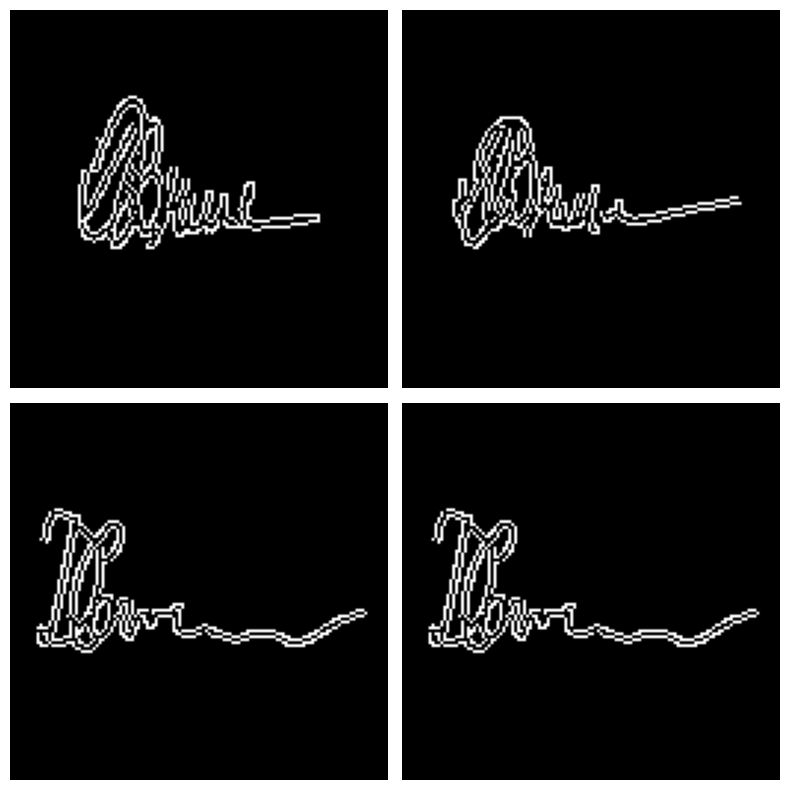

In [240]:
images = [imx1, imx2, imx3, imx4]

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Plot each image in the subplot
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap="gray")
    ax.axis("off")  # Hide the axis

plt.tight_layout()  # Adjusts spacing between images
plt.show()

In [241]:
def sign_verification(i1, i2):
    i1 = np.expand_dims(i1, axis=0)   # Shape becomes (1, 128, 128)

    i2 = np.expand_dims(i2, axis=0)   # Shape becomes (1, 128, 128)

    input_data = [{"image1": i1, "image2": i2}]
    prediction = model.predict(input_data)

    return prediction

In [243]:
print (sign_verification(np.array(imx1), np.array(imx1)))
print (sign_verification(np.array(imx1), np.array(imx2)))
print ('------------------------------')
print (sign_verification(np.array(imx1), np.array(imx3)))
print (sign_verification(np.array(imx2), np.array(imx3)))
print ('------------------------------')
print (sign_verification(np.array(imx3), np.array(imx4)))

1/1 [==============================] - 0s 30ms/step
[[0.42803824]]
1/1 [==============================] - 0s 35ms/step
[[0.26445237]]
------------------------------
1/1 [==============================] - 0s 20ms/step
[[0.9021398]]
1/1 [==============================] - 0s 23ms/step
[[0.70843923]]
------------------------------
1/1 [==============================] - 0s 20ms/step
[[0.42803824]]
